0. outside the notebook: 
    (with the final resmico model)
    produce and save predictions and embeddings with flags: --embeddings --emb-ind=-4
    now, only 10k samples will get predictions and indecies are not needed  
1. load csv for novel family and cami data
2. add 'avg_coverage' info using contig reader (will not work if it was not filled for new dataset)
3. change embedding format and create 'new' column
4. fit 2d umap on novel family data
5. transform other data
6. plot results


In [1]:
import umap
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

2022-01-13 22:41:19.402004: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import sys
sys.path.insert(1, '/cluster/home/omineeva/ResMiCo')
from resmico import contig_reader
from resmico import models_fl as Models

In [3]:
project_path = '/cluster/home/omineeva/global_projects/projects/projects2019-contig_quality/'
save_path = project_path + 'Outputs/predictions/'

In [4]:
preds_df_gut = pd.read_csv(save_path+'emb-gut-daniel_aucPR_0.657.csv')
# preds_df_oral = pd.read_csv(save_path+'emb-cami-daniel_aucPR_0.657.csv')
# preds_df_skin = pd.read_csv(save_path+'emb-skin-daniel_aucPR_0.657.csv')

preds_df_cami_error = pd.read_csv(save_path+'emb-camierror-daniel_aucPR_0.657.csv')

preds_df = pd.read_csv(save_path+'emb-family-daniel_aucPR_0.657.csv')

In [6]:
def fraq_ind(size, fraq):
    sel_ind = np.arange(size)
    num = int(fraq * size)
    np.random.shuffle(sel_ind)
    return sel_ind[:num] 

In [7]:
fraq = 0.005
sel_ind = fraq_ind(preds_df.shape[0], fraq)
fraq = 0.005
sel_ind_cami_error = fraq_ind(preds_df_cami_error.shape[0], fraq)
fraq = 0.02
sel_ind_g = fraq_ind(preds_df_gut.shape[0], fraq)
# sel_ind_o = fraq_ind(preds_df_oral.shape[0], fraq)
# sel_ind_s = fraq_ind(preds_df_skin.shape[0], fraq)

In [8]:
len(sel_ind), len(sel_ind_cami_error), len(sel_ind_g)#, len(sel_ind_o), len(sel_ind_s)

(9290, 10616, 8729)

In [9]:
preds_df = preds_df.iloc[sel_ind].reset_index()
preds_df_cami_error = preds_df_cami_error.iloc[sel_ind_cami_error].reset_index()


preds_df_gut = preds_df_gut.iloc[sel_ind_g].reset_index()
# preds_df_oral = preds_df_oral.iloc[sel_ind_o].reset_index()
# preds_df_skin = preds_df_skin.iloc[sel_ind_s].reset_index()

In [10]:
preds_df['new'] = preds_df['embedding'].apply(lambda x: np.fromstring(x, dtype=np.float, sep='|' ))
preds_df_cami_error['new'] = preds_df_cami_error['embedding'].apply(lambda x: np.fromstring(x, dtype=np.float, sep='|' ))
# preds_df_oral['new'] = preds_df_oral['embedding'].apply(lambda x: np.fromstring(x, dtype=np.float, sep='|' ))
preds_df_gut['new'] = preds_df_gut['embedding'].apply(lambda x: np.fromstring(x, dtype=np.float, sep='|' ))
# preds_df_skin['new'] = preds_df_skin['embedding'].apply(lambda x: np.fromstring(x, dtype=np.float, sep='|' ))

In [11]:
preds_df['tech'] = preds_df['cont_name'].apply(lambda x: x.split('/')[-2])
preds_df['sd'] = preds_df['cont_name'].apply(lambda x: x.split('/')[-3])
preds_df['read'] = preds_df['cont_name'].apply(lambda x: x.split('/')[-4])
preds_df['abd'] = preds_df['cont_name'].apply(lambda x: x.split('/')[-6])
preds_df['rch'] = preds_df['cont_name'].apply(lambda x: x.split('/')[-7])

In [12]:
preds_df_cami_error['tech'] = preds_df_cami_error['cont_name'].apply(lambda x: x.split('/')[-2])
preds_df_cami_error['sd'] = preds_df_cami_error['cont_name'].apply(lambda x: x.split('/')[-3])
preds_df_cami_error['read'] = preds_df_cami_error['cont_name'].apply(lambda x: x.split('/')[-4])
preds_df_cami_error['abd'] = preds_df_cami_error['cont_name'].apply(lambda x: x.split('/')[-6])
preds_df_cami_error['rch'] = preds_df_cami_error['cont_name'].apply(lambda x: x.split('/')[-7])

In [13]:
reducer = umap.UMAP(n_neighbors=15, random_state=111)

In [14]:
emb_data = np.stack(preds_df.new.values)
emb_data_cami_error = np.stack(preds_df_cami_error.new.values)
# emb_data_oral = np.stack(preds_df_oral.new.values)
emb_data_gut = np.stack(preds_df_gut.new.values)
# emb_data_skin = np.stack(preds_df_skin.new.values)

In [15]:
emb_data.shape

(9290, 128)

In [16]:
dim2_emb = reducer.fit_transform(emb_data)
dim2_emb.shape

(9290, 2)

In [17]:
dim2_emb_cami_error = reducer.transform(emb_data_cami_error)
# dim2_emb_o = reducer.transform(emb_data_oral)
dim2_emb_g = reducer.transform(emb_data_gut)
# dim2_emb_s = reducer.transform(emb_data_skin)
dim2_emb_g.shape

(8729, 2)

In [19]:
# convoluted_size = lambda len, pad: 0
# def gc(ind, reader):
#     predict_data = Models.BinaryDatasetEval(reader, [ind], ['ref_base'], 5000, max(250, 5000-500),
#                                             int(3 * 1e9 * 0.8), cache_results=False,
#                                             show_progress=False, convoluted_size=convoluted_size, pad_to_max_len=False)
#     cf = predict_data.__getitem__(0)
#     #['ref_base_A', 'ref_base_C', 'ref_base_G', 'ref_base_T']
#     return np.mean(cf[0][0][0][:,1] + cf[0][0][0][:,2])

In [54]:
feature_files_path = project_path + 'data/v2/resmico-sm/GTDBr202_n9k_novel-family_test/features/'
reader = contig_reader.ContigReader(feature_files_path, ['ref_base'], process_count=1, 
                                    is_chunked=False)

family_name2cov = {}
# family_name2gc = {}

    
for ind in range(len(reader)):
    contig = reader.contigs[ind]
    name = contig.file[:-len('features_binary')]+contig.name
    family_name2cov[name] = contig.avg_coverage
#     family_name2gc[name] = gc(ind, reader)
    
# #cami error
# feature_files_path = project_path + 'data/v2/resmico-sm/GTDBr202_n9k_train/cami_err/features/'
# reader = contig_reader.ContigReader(feature_files_path, ['ref_base'], process_count=1, 
#                                     is_chunked=False)

# cami_error_name2cov = {}
# for contig in reader.contigs:
#     cami_error_name2cov[contig.file[:-len('features_binary')]+contig.name] = contig.avg_coverage
    
    
# # #oral
# # feature_files_path = project_path + 'data/CAMI/CAMI2_HMP-oral/short_read/ResMiCo-SM/features/'
# # reader = contig_reader.ContigReader(feature_files_path, ['coverage'], process_count=1, 
# #                                     is_chunked=False)

# # oral_name2cov = {}
# # for contig in reader.contigs:
# #     oral_name2cov[contig.file[:-len('features_binary')]+contig.name] = contig.avg_coverage
# # gut    
# feature_files_path = project_path + 'data/CAMI/CAMI2_HMP-gut/short_read/ResMiCo-SM/features/'
# reader = contig_reader.ContigReader(feature_files_path, ['ref_base'], process_count=1, 
#                                     is_chunked=False)
# gut_name2cov = {}
# # gut_name2gc = {}
# for ind in sel_ind_g:
#     contig = reader.contigs[ind]
#     name = contig.file[:-len('features_binary')]+contig.name
#     gut_name2cov[name] = contig.avg_coverage
# #     gut_name2gc[name] = gc(ind, reader)

# # #skin    
# # feature_files_path = project_path + 'data/CAMI/CAMI2_HMP-skin/short_read/ResMiCo-SM/features/'
# # reader = contig_reader.ContigReader(feature_files_path, ['coverage', 'ref_base'], process_count=1, 
# #                                     is_chunked=False)

# # skin_name2cov = {}
# # for contig in reader.contigs:
# #     skin_name2cov[contig.file[:-len('features_binary')]+contig.name] = contig.avg_coverage

In [56]:
len(reader)

5169480

In [55]:
len(family_name2cov)

5169480

In [57]:
preds_df['avg_coverage'] = preds_df['cont_name'].map(family_name2cov)
# preds_df_cami_error['avg_coverage']  = preds_df_cami_error['cont_name'].map(cami_error_name2cov)
# preds_df_oral['avg_coverage'] = preds_df_oral['cont_name'].map(oral_name2cov)
# preds_df_gut['avg_coverage'] = preds_df_gut['cont_name'].map(gut_name2cov)
# preds_df_skin['avg_coverage'] = preds_df_skin['cont_name'].map(skin_name2cov)

In [22]:
# preds_df['gc'] = preds_df['cont_name'].map(family_name2gc)
# preds_df_gut['gc'] = preds_df_gut['cont_name'].map(gut_name2gc)

In [23]:
import matplotlib

cmap = matplotlib.cm.get_cmap('viridis')

rgba = cmap(0.5)

/cluster/home/omineeva/global_projects/projects/projects2019-contig_quality/Outputs/figures/umap_joint.pdf


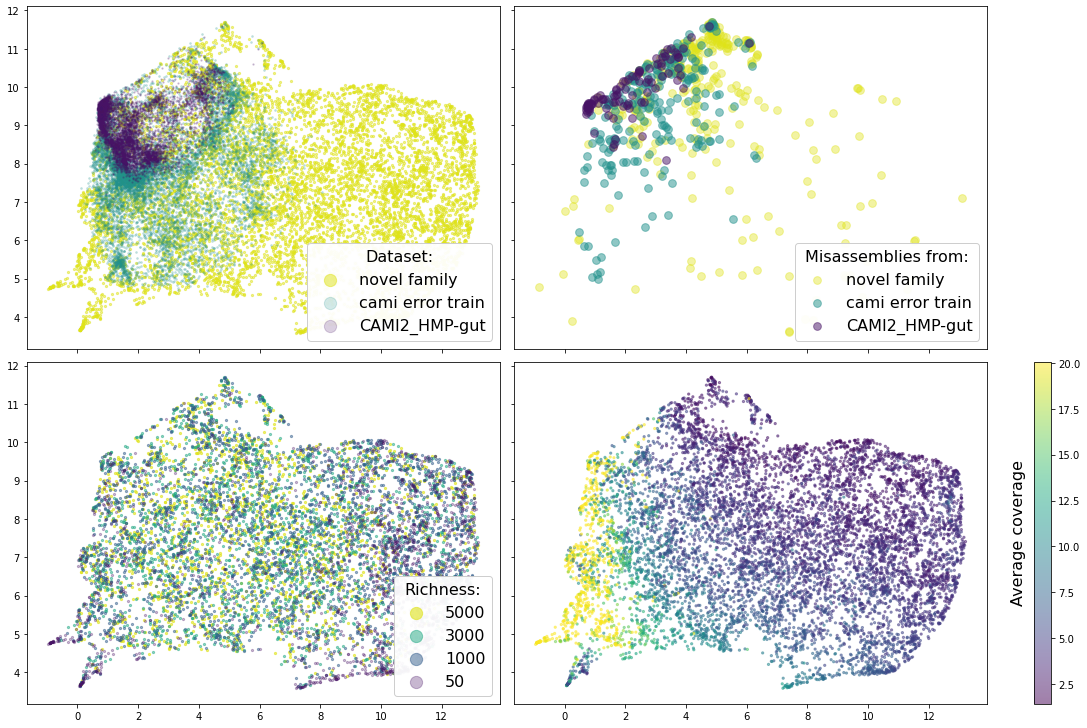

In [68]:
#plot joint
fig, axs = plt.subplots(2, 2, figsize=(15, 10), constrained_layout=True,
                                    sharey = True, sharex = True)#, 
#                                     gridspec_kw={'width_ratios': [6,  7]})
# fig.subplots_adjust(wspace=0.05)


axs[0][0].scatter(
    dim2_emb[:, 0], dim2_emb[:, 1],
    alpha=0.5, c=cmap(0.95), s=5,
    label = 'novel family')

axs[0][0].scatter(
    dim2_emb_cami_error[:, 0], dim2_emb_cami_error[:, 1],
    alpha=0.2, c=cmap(0.5), s=3,
    label = 'cami error train')

axs[0][0].scatter(
    dim2_emb_g[:, 0], dim2_emb_g[:, 1], alpha=0.2,
    c=cmap(0.05), s=2, label = 'CAMI2_HMP-gut')

#plot errors
axs[0][1].scatter(
    dim2_emb[:, 0][preds_df.label>0], dim2_emb[:, 1][preds_df.label>0],
    c=cmap(0.95), s=60, alpha=0.4,
    label = 'novel family')

axs[0][1].scatter(
    dim2_emb_cami_error[:, 0][preds_df_cami_error.label>0], dim2_emb_cami_error[:, 1][preds_df_cami_error.label>0],
    c=cmap(0.5), s=60, alpha=0.5,
    label = 'cami error train')

axs[0][1].scatter(
    dim2_emb_g[:, 0][preds_df_gut.label>0], dim2_emb_g[:, 1][preds_df_gut.label>0], 
    c=cmap(0.05), s=60, alpha=0.5,
    label = 'CAMI2_HMP-gut')

rch_col = {'0.111111':2, '0.333333':3, '0.555555':4, '0.005555':1}

#plot richness
keys = sorted(list(rch_col.keys()))
i=3
inds = preds_df.rch == keys[i]
axs[1][0].scatter(
    dim2_emb[inds][:, 0], dim2_emb[inds][:, 1], c=cmap(0.95),
    alpha=0.6, s=5, label = round(9000*float(keys[i])))
i=2
inds = preds_df.rch == keys[i]
axs[1][0].scatter(
    dim2_emb[inds][:, 0], dim2_emb[inds][:, 1], c=cmap(0.6),
    alpha=0.5, s=5, label = round(9000*float(keys[i])))
i=1
inds = preds_df.rch == keys[i]
axs[1][0].scatter(
    dim2_emb[inds][:, 0], dim2_emb[inds][:, 1], c=cmap(0.3),
    alpha=0.5, s=5, label = round(9000*float(keys[i])))
i=0
inds = preds_df.rch == keys[i]
axs[1][0].scatter(
    dim2_emb[inds][:, 0], dim2_emb[inds][:, 1], c=cmap(0.05),
    alpha=0.3, s=5, label = round(9000*float(keys[i])))


m = axs[1][1].scatter(
    dim2_emb[:, 0], dim2_emb[:, 1],
    alpha=0.5,
    c=preds_df.avg_coverage,
    s=5,
    label = 'n9k')


lgnd = axs[0][0].legend(fontsize=16, title = "Dataset:", title_fontsize = 16, 
                        loc='lower right', framealpha=0.95)
for handle in lgnd.legendHandles:
    handle.set_sizes([150])
lgnd = axs[0][1].legend(fontsize=16, title = "Misassemblies from:", title_fontsize = 16, 
                        loc='lower right', framealpha=0.95)
lgnd = axs[1][0].legend(fontsize=16, title = "Richness:", title_fontsize = 16, 
                        loc='lower right', framealpha=0.95)
for handle in lgnd.legendHandles:
    handle.set_sizes([150])
# cbar = plt.colorbar(m, orientation="vertical")
cbar=fig.colorbar(m, ax=[axs[1, 1]], location='right')
cbar.ax.set_ylabel('Average coverage', rotation=90, fontsize=16, labelpad=-70)




where = os.path.join(save_path,'umap_joint.pdf')
plt.savefig(where, 
            bbox_inches='tight', format='pdf', dpi=300)
print(where)

plt.show()

In [67]:
save_path=project_path+'Outputs/figures'

#conclusions
all cami datasets share the space
cami_error closer to cami

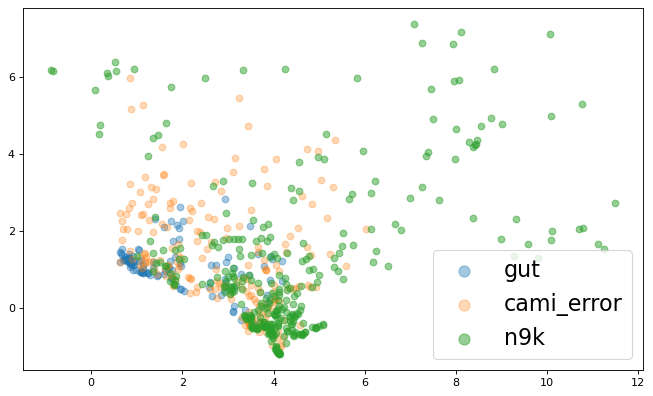

In [47]:
#PLOT SINGLE
plt.figure(figsize=(10, 6), dpi=80)

# plt.scatter(dim2_emb_o[:, 0], dim2_emb_o[:, 1], alpha=0.3,
# #     c=np.abs(preds_df_oral.score[sel_ind_o]-1*(preds_df_oral.label[sel_ind_o]>0)),
# #     c=1*(preds_df_oral.label[sel_ind_o]>0)   
#     s=preds_df_oral.avg_coverage[sel_ind_o]*5,
#     label='oral')

plt.scatter(dim2_emb_g[:, 0][preds_df_gut.label>0], dim2_emb_g[:, 1][preds_df_gut.label>0], alpha=0.4,
#     c=np.abs(preds_df_gut.score[sel_ind_g]-1*(preds_df_gut.label[sel_ind_g]>0)),
#     c=1*(preds_df_gut.label>0) , 
#             c='cyan',
#     c=preds_df_gut.gc,
#     c=preds_df_gut.avg_coverage,
#             s=5,
#             s=(preds_df_gut.label+1)*50,
    label = 'gut')

# plt.scatter(dim2_emb_s[:, 0], dim2_emb_s[:, 1], alpha=0.3,
# #     c=np.abs(preds_df_skin.score[sel_ind_s]-1*(preds_df_skin.label[sel_ind_s]>0)),
# #     c=1*(preds_df_skin.label[sel_ind_s]>0),  
#     s=preds_df_skin.avg_coverage[sel_ind_s]*5,
#     label = 'skin')

plt.scatter(
    dim2_emb_cami_error[:, 0][preds_df_cami_error.label>0], dim2_emb_cami_error[:, 1][preds_df_cami_error.label>0],
    alpha=0.3,
#     c=np.log10(preds_df_cami_error.length[sel_ind_cami_error]), 
    
#     c=preds_df_cami_error.label[sel_ind_cami_error], 
#     c=preds_df_cami_error.score[sel_ind_cami_error],
#     c=np.abs(preds_df_cami_error.score[sel_ind_cami_error]-1*(preds_df_cami_error.label[sel_ind_cami_error]>0)),
    
#     c=preds_df_cami_error.sd[sel_ind_cami_error].map(
#         {key:i for i, key in enumerate(preds_df_cami_error.sd.unique())}),
#     c=preds_df_cami_error.tech[sel_ind_cami_error].map(
#         {key:i for i, key in enumerate(preds_df_cami_error.tech.unique())}),
#     c=preds_df_cami_error.rch[sel_ind_cami_error].map(
#         {key:i for i, key in enumerate(preds_df_cami_error.rch.unique())}),
#     c=preds_df_cami_error.read[sel_ind_cami_error].map(
#         {key:i for i, key in enumerate(preds_df_cami_error.read.unique())}),
#     c=preds_df_cami_error.abd[sel_ind_cami_error].map(
#         {key:i for i, key in enumerate(preds_df_cami_error.abd.unique())}),
#     c=preds_df_cami_error.avg_coverage,
#     c='olive',
    
#     s=4,
#     s=(preds_df_cami_error.label[sel_ind_cami_error]+1)**5
    label = 'cami_error')


rch_col = {'0.111111':2, '0.333333':3, '0.555555':4, '0.005555':1}
plt.scatter(
    dim2_emb[:, 0][preds_df.label>0], dim2_emb[:, 1][preds_df.label>0],
    alpha=0.5,
#     c=np.log10(preds_df.length[sel_ind]), 
    c = 
#     c=preds_df.label, 
#     c=preds_df.score[sel_ind],
    c=np.abs(preds_df.score[sel_ind]-1*(preds_df.label[sel_ind]>0)),
    
#     c=preds_df.sd.map({key:i for i, key in enumerate(preds_df.sd.unique())}),
#     c=preds_df.tech.map({key:i for i, key in enumerate(preds_df.tech.unique())}),
#     c=preds_df.rch.map(rch_col),
#     c=preds_df.read.map({key:i for i, key in enumerate(preds_df.read.unique())}),
#     c=preds_df.abd.map({key:i for i, key in enumerate(preds_df.abd.unique())}),
#     c=preds_df.avg_coverage,
#     c=preds_df.gc,
#     c='deeppink',
    
#     s=50,
#     s=(preds_df.label+1)**5,
    label = 'n9k')


# #plot richness
# keys = sorted(list(rch_col.keys()))
# i=3
# inds = preds_df.rch == keys[i]
# plt.scatter(
#     dim2_emb[inds][:, 0], dim2_emb[inds][:, 1], c=cmap(0.05),
#     alpha=0.6, label = round(9000*float(keys[i])))
# i=2
# inds = preds_df.rch == keys[i]
# plt.scatter(
#     dim2_emb[inds][:, 0], dim2_emb[inds][:, 1], c=cmap(0.3),
#     alpha=0.5, label = round(9000*float(keys[i])))
# i=1
# inds = preds_df.rch == keys[i]
# plt.scatter(
#     dim2_emb[inds][:, 0], dim2_emb[inds][:, 1], c=cmap(0.6),
#     alpha=0.5, label = round(9000*float(keys[i])))
# i=0
# inds = preds_df.rch == keys[i]
# plt.scatter(
#     dim2_emb[inds][:, 0], dim2_emb[inds][:, 1], c=cmap(0.95),
#     alpha=0.3, label = round(9000*float(keys[i])))


# plt.gca().set_aspect('equal', 'datalim')

lgnd = plt.legend(fontsize=20)
for handle in lgnd.legendHandles:
    handle.set_sizes([100])
# cbar = plt.colorbar(orientation="vertical")
# cbar.ax.set_ylabel('average coverage', rotation=90, fontsize=16, labelpad=-70)

# plt.xlim(-2.1, 12.9)
# plt.ylim(1.9, 11)


# plt.title('UMAP projection', fontsize=24)

# where = os.path.join(save_path,'umap_cov.pdf')
# plt.savefig(where, 
#             bbox_inches='tight', format='pdf', dpi=300)
# print(where)

plt.show()